# Step 0: Imports

In [1]:
# using tqdm.auto glitches out collaborative editing
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl
import matplotlib.pyplot as plt, mpld3

from math import sqrt
from collections import deque
import os
import random
from concurrent.futures import ProcessPoolExecutor
import pickle

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda", "CUDA is not available. Please check your GPU setup."

In [2]:
# VTXS numbers here are inclusive
MIN_VTXS = 3
MAX_VTXS = 15
MAX_TUNE_VTXS = 7
AVG_DEG = 2
SEQ_LEN = MAX_VTXS + 1 # means 32 edges, final token is the target vertex
PAD_TOKEN = 0
EPOCH_SIZE = 2**20
# vertices are labelled 1,2,...,MAX_VTXS
# we also have a padding token which is 0.

# Step 1: Generate synthetic data

In [3]:
# original task data
# the data will be edge lists
# like this: [1 3 1 5 2 4 0 0 0 0 2]
# this represents edges (1,3), (1,5) (2,4)
# (the zeros are just padding tokens)
# the final 2 means which vertex we're going to 

# the label is the shortest distance from vtx 1 to vtx 2
# or "number of vertices" if no path exists

def random_graph(n):
    edge_list = []
    adjacencies = [set() for _ in range(n+1)]
    indices = [random.randint(1, n) for _ in range(AVG_DEG * n)]
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            if u < v:
                edge_list += [u, v]
            else:
                edge_list += [v, u]
            adjacencies[u].add(v)
            adjacencies[v].add(u)
    edge_list += [PAD_TOKEN]*(2*SEQ_LEN-1-len(edge_list))
    return edge_list, adjacencies

def SSSP(G, target=2, distonly=True):
    dist = [MAX_VTXS] * len(G)
    parent = [-1] * len(G)
    dist[1] = 0
    frontier = deque()
    frontier.append(1)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == MAX_VTXS:
                parent[x] = vtx
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    if distonly:
                        return dist[x]
                    path = [x]
                    while parent[x] != -1:
                        x = parent[x]
                        path.append(x)
                    return list(reversed(path))
    return MAX_VTXS if distonly else []

# large: size up to MAX_VTXS instead of MAX_TUNE_VTXS
# target: 2, "onpath", "any"
# largetarget: whether can go up to MAX_VTXS or just MAX_TUNE_VTXS
def mkbatch(size, large=True, target=2, largetarget=True):
    graphs = []
    dists = []
    
    for i in range(size):
        n = random.randint(MIN_VTXS, MAX_VTXS if large else MAX_TUNE_VTXS)
        while True:
            edge_list, adj_list = random_graph(n)
            if target == 2:
                # Train data
                dist = SSSP(adj_list)
                # Filter out some short distance graphs
                if 6 <= dist < MAX_VTXS or (dist < 6 and 2 * random.random() < 1 / (6 - dist)) or (dist == MAX_VTXS and random.random() < 1 / MAX_VTXS):
                    edge_list[-1] = 2
                    break
            elif target == "onpath":
                path = SSSP(adj_list, 2, False)
                if len(path) < 1:
                    continue
                dist = random.randrange(1, len(path))
                if largetarget or path[dist] <= MAX_TUNE_VTXS:
                    edge_list[-1] = path[dist]
                    break
            elif target == "any":
                edge_list[-1] = random.randint(2, MAX_VTXS if largetarget else MAX_TUNE_VTXS)
                dist = SSSP(adj_list, edge_list[-1])
                break
        graphs.append(edge_list)
        dists.append(dist)
    
    data = torch.tensor(graphs)
    labels = torch.tensor(dists, dtype=torch.float32)
    padding = data == PAD_TOKEN
    return data, labels, padding

def savebatch(size, idx):
    data, labels, padding = mkbatch(size)
    everything = {
        "data": data,
        "labels": labels,
        "padding": padding,
    }
    
    with open(f'data-new/{idx}.pickle', 'wb') as file:
        pickle.dump(everything, file)

In [5]:
# Only need to run this once to generate training data
# RESTART THE KERNEL BEFORE RUNNING AND ONLY RUN THE CELLS ABOVE
# Python is slow and awful

# with ProcessPoolExecutor() as executor:
#     for i in range(64):
#         executor.submit(savebatch, EPOCH_SIZE, i)
#     executor.shutdown()

In [95]:
mkbatch(3)

(tensor([[1, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 2],
         [1, 5, 3, 4, 1, 3, 4, 5, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 2],
         [2, 9, 1, 3, 4, 8, 8, 9, 3, 9, 5, 7, 6, 7, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 2]]),
 tensor([ 1., 15.,  3.]),
 tensor([[False, False, False, False,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          False],
         [False, False, False, False, False, False, False, False, False, False,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, Fal

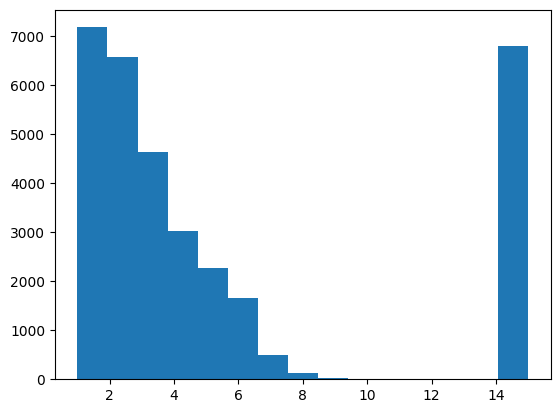

In [6]:
plt.hist(mkbatch(2**15)[1].cpu(), bins=MAX_VTXS)
with open("train-dist.html", "w") as f:
    mpld3.save_html(plt.gcf(), f)

(array([2.4747e+04, 6.5340e+03, 1.2840e+03, 1.8300e+02, 2.0000e+01]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

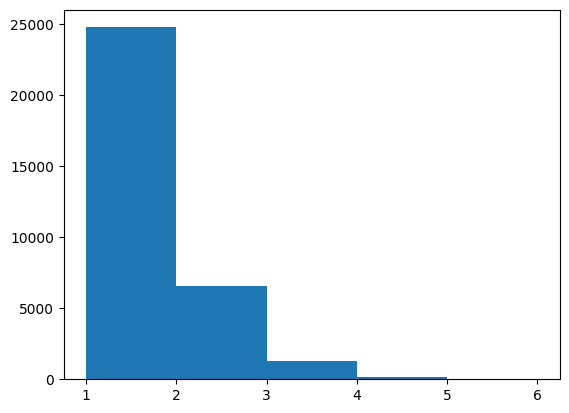

In [7]:
plt.hist(mkbatch(2**15, large=False, target="onpath")[1].cpu(), bins=5)

(array([2.0379e+04, 7.8380e+03, 3.0080e+03, 1.0690e+03, 3.4600e+02,
        9.8000e+01, 2.5000e+01, 5.0000e+00]),
 array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 8 artists>)

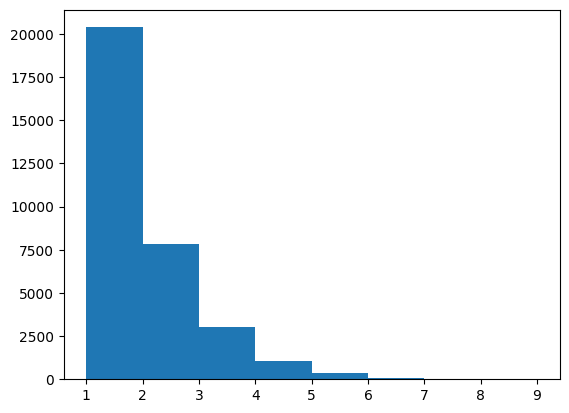

In [13]:
plt.hist(mkbatch(2**15, large=True, target="onpath", largetarget=False)[1].cpu(), bins=8)

# Step 2: Define Transformer Model

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, dropout):
        super().__init__()
        self.model_dim = model_dim
        self.embedding = nn.Embedding(input_dim, model_dim // 2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads,
                                                   dim_feedforward=model_dim*4,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src, key_padding_mask):
        batch_sz = src.size(0)
        src = torch.cat((src, torch.full((batch_sz, 1), MAX_VTXS + 1, device=device)), dim=1)
        embed = torch.cat((self.embedding(src[:,::2]), self.embedding(src[:,1::2])), dim=2)
        output = self.transformer_encoder(embed, src_key_padding_mask=key_padding_mask[:, ::2])
        return self.fc_out(output[:, -1, :])

# Step 3: Make Model

In [16]:
# PARAMS
VOCAB_SIZE = 1 + MAX_VTXS + 1 # pad plus max number of vertices plus target token
MODEL_DIM = 64 # Dimension of model (embedding and transformer)
NEPOCHS = 100
BSZ = 2**15 # Batch size
NHEADS = 2
NLAYERS = 11
DROPOUT = 0 # 0.2
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
                         output_dim=1, num_heads=NHEADS,
                         num_layers=NLAYERS, seq_len=SEQ_LEN,
                         dropout=DROPOUT).to(device)
model = torch.compile(model)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training data: {NEPOCHS*EPOCH_SIZE//10**3}K")
print(f"Trainable parameters in the model: {trainable_params}")

train_err = []
len1 = []
len2 = []
len3 = []
leninf = []
epoch = 0

# clear loss file
open('loss', 'w').close()

Training data: 104857K
Trainable parameters in the model: 550433


In [20]:
# model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=MODEL_DIM,
#                          output_dim=1, num_heads=NHEADS,
#                          num_layers=NLAYERS, seq_len=SEQ_LEN,
#                          dropout=DROPOUT).to(device)
# model = torch.compile(model)
# model.load_state_dict(torch.load('model.pth', weights_only=True))

LR = 5e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Step 4: Train the Model for the first task

In [ ]:
while epoch < NEPOCHS:
    model.train()
    with open(f"data/{epoch}.pickle", "rb") as f:
        pickled_stuff = pickle.load(f)
    data = pickled_stuff["data"].to(device)
    label = pickled_stuff["labels"].to(device).to(torch.float32)
    padding = pickled_stuff["padding"].to(device)
    dataset = TensorDataset(data, label, padding)
    loader = DataLoader(dataset, batch_size=BSZ)
    for batch_src, batch_labels, batch_padding_mask in tqdm(loader):
        optimizer.zero_grad()
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
        loss.backward()
        optimizer.step()
        
        train_err.append(loss.item())
        len1.append(criterion(output[batch_labels == 1].squeeze(1), batch_labels[batch_labels == 1]).item())
        len2.append(criterion(output[batch_labels == 2].squeeze(1), batch_labels[batch_labels == 2]).item())
        len3.append(criterion(output[batch_labels == 3].squeeze(1), batch_labels[batch_labels == 3]).item())
        leninf.append(criterion(output[batch_labels == MAX_VTXS].squeeze(1), batch_labels[batch_labels == MAX_VTXS]).item())
        
        with open('loss', 'a') as f:
            f.write(f"{train_err[-1]} {len1[-1]} {len2[-1]} {len3[-1]} {leninf[-1]}\n")
    epoch_err = lambda l: sum(l[-EPOCH_SIZE // BSZ:]) / EPOCH_SIZE * BSZ
    print(f"Epoch {epoch}/{NEPOCHS} \t Train Err: {epoch_err(train_err)} {epoch_err(len1)} {epoch_err(len2)} {epoch_err(len3)} {epoch_err(leninf)}")

    epoch += 1
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"checkpoints/model_weights_{epoch}.pth")

/tmp/torchinductor_sipb/lc/clcqc3ufbzrethiy77dmsu54kurxdmh4eji2f3msm347rhmfpf4j.py:1078: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  extern_kernels.mm(reinterpret_tensor(buf1, (524288, 64), (64, 1), 0), reinterpret_tensor(primals_5, (64, 192), (1, 64), 0), out=buf2)

00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:42<00:00,  1.33s/it]

Epoch 0/100 	 Train Err: 48.97900426387787 12.91722442075843 7.231296321027912 3.5385852727340534 115.3402452468872



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 1/100 	 Train Err: 41.59842586517334 23.066684544086456 14.473573058843613 7.877466633915901 84.72042870521545



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 2/100 	 Train Err: 40.415191769599915 29.482473254203796 19.633903205394745 11.77738669514656 73.48623991012573



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 3/100 	 Train Err: 40.01692616939545 32.29490512609482 22.276952624320984 13.907412678003311 68.378258228302



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 4/100 	 Train Err: 31.416786193847656 2.3271487059355422 26.761382937431335 18.088589638471603 60.98844397068024



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 5/100 	 Train Err: 25.921700596809387 0.22728093068872113 19.57061032950878 15.32799781858921 52.15890157222748



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 6/100 	 Train Err: 17.580547362565994 0.021982330930768512 4.470714939758182 19.619352281093597 36.34695905447006



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 7/100 	 Train Err: 12.400098770856857 0.013556713653088082 0.5100052966736257 23.03424423933029 23.36328774690628



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 8/100 	 Train Err: 9.38240310549736 0.007538945435953792 0.22025173716247082 19.04077085852623 16.662322163581848



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 9/100 	 Train Err: 7.412262797355652 0.008171883615432307 0.1555994711816311 14.766773402690887 12.345462799072266



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 10/100 	 Train Err: 6.162406742572784 0.017439005838241428 0.14521901519037783 10.868462145328522 10.12831449508667



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 11/100 	 Train Err: 5.102278828620911 0.006056587655621115 0.07073448912706226 7.790802486240864 8.321609899401665



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 12/100 	 Train Err: 4.366904504597187 0.005133508995641023 0.059961416525766253 5.993938364088535 6.998718574643135



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 13/100 	 Train Err: 3.831405833363533 0.003056721754546743 0.04472046362934634 4.653905652463436 6.165115922689438



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 14/100 	 Train Err: 3.4279200956225395 0.004735801303468179 0.03825691540259868 3.906827114522457 5.425094351172447



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 15/100 	 Train Err: 3.138390600681305 0.005375595836085267 0.03724290645914152 3.326357141137123 4.948893174529076



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 16/100 	 Train Err: 2.899445064365864 0.006989890585828107 0.041147086303681135 2.920688170939684 4.558141328394413



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 17/100 	 Train Err: 2.6482545658946037 0.006691730450256728 0.03093722724588588 2.4344960935413837 4.143990509212017



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 18/100 	 Train Err: 2.4724042862653732 0.013588363406597637 0.03676938998978585 2.2025532834231853 3.8459226489067078



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 19/100 	 Train Err: 2.2938634902238846 0.007989803227246739 0.031059849599841982 1.9167942628264427 3.582200199365616



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 20/100 	 Train Err: 2.0970346182584763 0.004351407576905331 0.02517502213595435 1.652792677283287 3.244159609079361



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 21/100 	 Train Err: 1.974123526364565 0.003171493917761836 0.02390849226503633 1.4561462700366974 3.0673259645700455



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 22/100 	 Train Err: 1.8447572737932205 0.0030846048357489053 0.021993933914927766 1.3033475428819656 2.8325533121824265



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 23/100 	 Train Err: 1.6970642134547234 0.002785886717902031 0.020618034002836794 1.1004324741661549 2.604609090834856



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 24/100 	 Train Err: 1.5955667905509472 0.003940593182051089 0.02032866739318706 0.976159205660224 2.466688357293606



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 25/100 	 Train Err: 1.4617242440581322 0.002876215428841533 0.018645043048309162 0.8556559775024652 2.229958161711693



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 26/100 	 Train Err: 1.3831324987113476 0.004849277267567231 0.02050616717315279 0.7726096417754889 2.099547818303108



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 27/100 	 Train Err: 1.311477318406105 0.0024031923712755088 0.01927993548451923 0.7051676390692592 1.976257335394621



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 28/100 	 Train Err: 1.207214828580618 0.0035346322583791334 0.018441367952618748 0.6115700239315629 1.8264076933264732



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 29/100 	 Train Err: 1.1089427508413792 0.00329247322952142 0.0165127256186679 0.5199616495519876 1.6691240929067135



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 30/100 	 Train Err: 1.029175629839301 0.002865927770471899 0.01539153911289759 0.4984441949054599 1.5174495466053486



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 31/100 	 Train Err: 0.9538682177662849 0.0023230986480484717 0.01537516585085541 0.4138944335281849 1.406083919107914



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 32/100 	 Train Err: 0.8980342578142881 0.0015845673569856444 0.014839567360468209 0.40191424917429686 1.3131387010216713



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 33/100 	 Train Err: 0.8195682223886251 0.0034502551516197855 0.014685693866340443 0.3501896969974041 1.191128795966506



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 34/100 	 Train Err: 0.7459018900990486 0.0021442237539304188 0.014179074845742434 0.31923429761081934 1.0604591444134712



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 35/100 	 Train Err: 0.7101908139884472 0.0032578711288806517 0.014129422343103215 0.2923557236790657 1.0151417199522257



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 36/100 	 Train Err: 0.6644597053527832 0.0026260755184921436 0.012881889037089422 0.257190125528723 0.9443178754299879



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 37/100 	 Train Err: 0.6029678452759981 0.0022337357859214535 0.013130559556884691 0.232837010640651 0.837149228900671



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.03it/s]

Epoch 38/100 	 Train Err: 0.5509444028139114 0.0019162936450811685 0.012294809013837948 0.2053068270906806 0.7741311714053154



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 39/100 	 Train Err: 0.5144137293100357 0.0014641922125520068 0.009304212289862335 0.18962949723936617 0.6982439709827304



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.04it/s]

Epoch 40/100 	 Train Err: 0.4911631550639868 0.0034183577554358635 0.011847828980535269 0.17764808260835707 0.6830073017627001



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:31<00:00,  1.02it/s]

Epoch 41/100 	 Train Err: 0.44534157309681177 0.002719711333156738 0.011579871497815475 0.17093974631279707 0.5986328851431608



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 42/100 	 Train Err: 0.4234167579561472 0.0020350335244074813 0.010087796414154582 0.1561200835276395 0.5679095359519124



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 43/100 	 Train Err: 0.38217254262417555 0.001672563766987878 0.008801718227914535 0.1451707179658115 0.5035076225176454



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:30<00:00,  1.03it/s]

Epoch 44/100 	 Train Err: 0.36583498027175665 0.0006311295665000216 0.0070743790856795385 0.13195386109873652 0.4824865907430649


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 22/32 [00:21<00:09,  1.06it/s]

In [16]:
# """
# Now let's figure out what it's doing. 

# step 1: figure out what people are attending to 
# """

# example_graph, answer, padding = mkbatch(1)
# sentance_embeddings = model.full_embedding(example_graph)[0,:,:][example_graph.flatten() != 0]
# WQ,WK,WV = torch.split(model.transformer_encoder.layers[0].self_attn.in_proj_weight, (MODEL_DIM, MODEL_DIM, MODEL_DIM))

# Q = sentance_embeddings@WQ
# K = sentance_embeddings@WK

# raw_scores = Q @ K.T / sqrt(MODEL_DIM)
# soft = torch.softmax(raw_scores, dim=-1).detach().cpu().to(float).numpy()
# plt.imshow(soft)
# plt.show()

# print(example_graph)

# print(Q)

In [ ]:
with open('training-loss') as f:
    train_err = list(map(float, f.read().split()))
    plt.suptitle('Log MSE vs Epochs')
    plt.plot(torch.log(torch.tensor(train_err)[:500]), label='Train', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Log MSE')
    plt.show()

plt.suptitle('Log MSE vs Epochs')
plt.plot(torch.log(torch.tensor(train_err)), label='Train', color='blue')
plt.plot(torch.log(torch.tensor(len1)).to(torch.float16), label='Len 1', color='red')
plt.plot(torch.log(torch.tensor(len2)).to(torch.float16), label='Len 2', color='green')
plt.plot(torch.log(torch.tensor(len3)).to(torch.float16), label='Len 3', color='yellow')
plt.plot(torch.log(torch.tensor(len15)).to(torch.float16), label='Len 15', color='magenta')
plt.xlabel('Epochs')
plt.ylabel('Log MSE')
plt.legend()
plt.show()

In [1]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.uint8)
y = output.detach()
cnts = torch.bincount(x)
weights = [1/cnts[i.item()].item() for i in x] # normalize by label count
fig, ax = plt.subplots()
h = ax.hist2d(x.cpu().numpy().flatten(), y.to(torch.float16).cpu().numpy().flatten(), weights=weights, bins=[15,50], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax=ax)
plt.show()

NameError: name 'mkbatch' is not defined

In [10]:
def evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mkbatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

evaluate()

/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:871: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return torch._transformer_encoder_layer_fwd(
/home/sipb/.venv/lib64/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


0.0005554668023250997

# Step 5: Fine Tune

In [11]:
N_TUNE_EPOCHS = 100
TUNE_LR = 1e-5
TUNE_WD = 0 # 1e-5

tune_criterion = nn.MSELoss()
tune_optimizer = torch.optim.Adam(model.parameters(), lr=TUNE_LR, weight_decay=TUNE_WD)

tune_train_err = []

# clear loss file
open('tune_loss', 'w').close()

In [15]:
for epoch in range(N_TUNE_EPOCHS):
    model.train()
    train_loss = 0
    batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
    optimizer.zero_grad()
    output = model(batch_src, batch_padding_mask)
    loss = criterion(output.squeeze(1), batch_labels)
    train_loss = loss.item()
    loss.backward()
    optimizer.step()
    
    tune_train_err.append(train_loss)
    with open('tune_loss', 'a') as f:
        f.write(f"{train_loss}\n")
    print(f"Epoch {epoch}/{N_TUNE_EPOCHS} \t Train Err: {train_loss:.4f}")

    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"checkpoints/tune_model_weights_{epoch + 1}.pth")

Epoch 0/100 	 Train Err: 0.4553
Epoch 1/100 	 Train Err: 0.2545
Epoch 2/100 	 Train Err: 0.2368
Epoch 3/100 	 Train Err: 0.2138
Epoch 4/100 	 Train Err: 0.1898
Epoch 5/100 	 Train Err: 0.1931
Epoch 6/100 	 Train Err: 0.1948
Epoch 7/100 	 Train Err: 0.1847
Epoch 8/100 	 Train Err: 0.1638
Epoch 9/100 	 Train Err: 0.1490
Epoch 10/100 	 Train Err: 0.1457
Epoch 11/100 	 Train Err: 0.1509
Epoch 12/100 	 Train Err: 0.1537
Epoch 13/100 	 Train Err: 0.1472
Epoch 14/100 	 Train Err: 0.1369
Epoch 15/100 	 Train Err: 0.1304
Epoch 16/100 	 Train Err: 0.1257
Epoch 17/100 	 Train Err: 0.1201
Epoch 18/100 	 Train Err: 0.1160
Epoch 19/100 	 Train Err: 0.1064
Epoch 20/100 	 Train Err: 0.1026
Epoch 21/100 	 Train Err: 0.0964
Epoch 22/100 	 Train Err: 0.1165
Epoch 23/100 	 Train Err: 0.0990
Epoch 24/100 	 Train Err: 0.0691
Epoch 25/100 	 Train Err: 0.0633
Epoch 26/100 	 Train Err: 0.0552
Epoch 27/100 	 Train Err: 0.0505
Epoch 28/100 	 Train Err: 0.0429
Epoch 29/100 	 Train Err: 0.0376
Epoch 30/100 	 Train

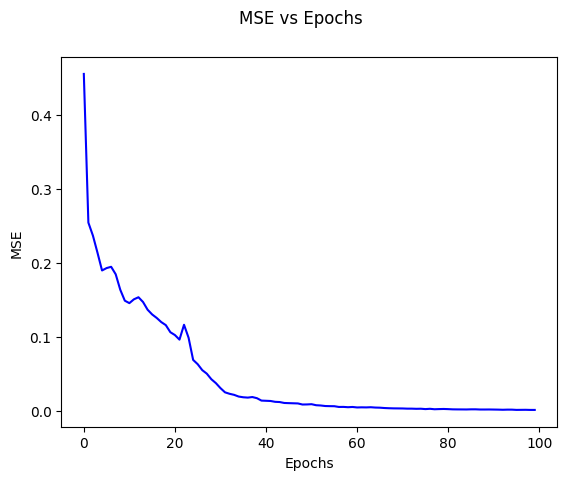

In [17]:
plt.suptitle('MSE vs Epochs')
plt.plot(tune_train_err, label='Train', color='blue')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [19]:
def tune_evaluate():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
        output = model(batch_src, batch_padding_mask)
        loss = criterion(output.squeeze(1), batch_labels)
    return loss.item()

tune_evaluate()

0.001733972690999508

(array([[6.0290e+03, 1.8597e+04, 8.4000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00]]),
 array([1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  , 1.699, 1.8  ,
        1.9  , 2.   , 2.1  , 2.2  , 2.3  , 2.398, 2.5  , 2.6  , 2.7  ,
        2.8  , 2.898, 3.   , 3.1  , 3.2  , 3.299, 3.398, 3.5  , 3.6  ,
        3.7  , 3.799, 3.898, 4.   , 4.1  , 4.2  , 4.297, 4.4  , 4.5  ,
        4.6  , 4.7  , 4.797, 4.9  , 5.   , 5.098, 5.2  , 5.3  , 5.4  ,
        5.5  , 5.598, 5.7  , 5.797, 5.9  , 6.   ], dty

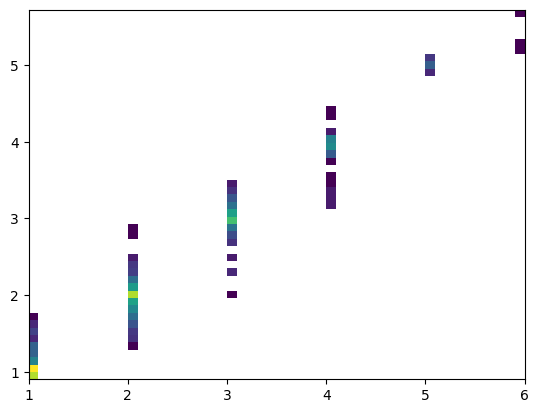

In [21]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())

# Step 6: Test generalization

0.20130713284015656


(array([[1.7789e+04, 6.5000e+02, 4.8000e+02, ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([ 1.   ,  1.18 ,  1.36 ,  1.54 ,  1.721,  1.9  ,  2.08 ,  2.262,
         2.441,  2.621,  2.8  ,  2.98 ,  3.16 ,  3.34 ,  3.521,  3.701,
         3.88 ,  4.062,  4.242,  4.42 ,  4.6  ,  4.78 ,  4.96 ,  5.14 ,
         5.32 ,  5.5  ,  5.68 ,  5.863,  6.043,  6.223,  6.402,  6.582,
         6.76 ,  6.94 ,  7.12 ,  7.3  ,  7.48 ,  7.66 ,  7.844,  8.02 ,
         8.2  ,  8.38 ,  8.56 ,  8.74 ,  8.92 ,  

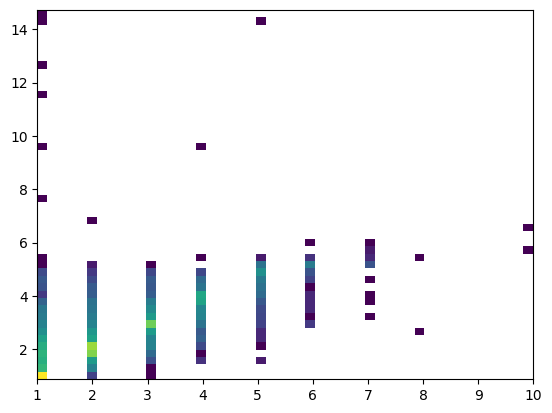

In [27]:
batch_src, batch_labels, batch_padding_mask = map(lambda x: x.to(device), mktunebatch(BSZ, test=True))
model.eval()
with torch.no_grad():
    output = model(batch_src, batch_padding_mask)
print(criterion(output.squeeze(1), batch_labels).item())
x = batch_labels.detach().to(torch.float16).cpu().numpy().flatten()
y = output.detach().to(torch.float16).cpu().numpy().flatten()
plt.hist2d(x, y, bins=50, norm=mpl.colors.LogNorm())